In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

nltk.download("inaugural")

[nltk_data] Downloading package inaugural to /home/vscode/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [3]:
from typing import Final, TypeAlias

import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import inaugural

from authorship_tool.types_ import Para2dStr, Tag
from authorship_tool.util import dim_reshaper
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import cv_trainer
from authorship_tool.util.ml.model import (
    CrossValidationResult,
    CvGlobalExplanationData,
    LGBMSource,
    Score,
    TrainingResult,
    pred_crosstab,
)
from authorship_tool.util.path_util import InauguralLoocvPaths

Project root: /workspaces/shap-authorship-analysis-demo
Path: data/john_blake_2023/wordLists/adjectives/participle/adjectivesPastParticiple.csv
Path: data/john_blake_2023/wordLists/adjectives/participle/adjectivesPresentParticiple.csv
Path: data/john_blake_2023/wordLists/adjectives/limit/limit_adjectives.csv
Path: data/john_blake_2023/wordLists/adjectives/extraposition/adjectives_extraposition.csv
Path: data/liyanage_vijini_2022/Dataset/FullyGenerated
Path: data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset
Path: data/uoa-thesis-2014-2017
Path: out/text_data
Path: out/processed_text
Path: out/dataset
Path: out/lgbm/model
Path: out/shap/figure


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
PRESIDENT_A = "Obama"
PRESIDENT_B = "Bush"

In [6]:
for idx, file_id in enumerate(inaugural.fileids()):
    if "1989" in file_id:
        file_id = file_id.replace("Bush", "H.W.Bush")
    print(f"#{idx+1}\t{file_id[:-4]}")

#1	1789-Washington
#2	1793-Washington
#3	1797-Adams
#4	1801-Jefferson
#5	1805-Jefferson
#6	1809-Madison
#7	1813-Madison
#8	1817-Monroe
#9	1821-Monroe
#10	1825-Adams
#11	1829-Jackson
#12	1833-Jackson
#13	1837-VanBuren
#14	1841-Harrison
#15	1845-Polk
#16	1849-Taylor
#17	1853-Pierce
#18	1857-Buchanan
#19	1861-Lincoln
#20	1865-Lincoln
#21	1869-Grant
#22	1873-Grant
#23	1877-Hayes
#24	1881-Garfield
#25	1885-Cleveland
#26	1889-Harrison
#27	1893-Cleveland
#28	1897-McKinley
#29	1901-McKinley
#30	1905-Roosevelt
#31	1909-Taft
#32	1913-Wilson
#33	1917-Wilson
#34	1921-Harding
#35	1925-Coolidge
#36	1929-Hoover
#37	1933-Roosevelt
#38	1937-Roosevelt
#39	1941-Roosevelt
#40	1945-Roosevelt
#41	1949-Truman
#42	1953-Eisenhower
#43	1957-Eisenhower
#44	1961-Kennedy
#45	1965-Johnson
#46	1969-Nixon
#47	1973-Nixon
#48	1977-Carter
#49	1981-Reagan
#50	1985-Reagan
#51	1989-H.W.Bush
#52	1993-Clinton
#53	1997-Clinton
#54	2001-Bush
#55	2005-Bush
#56	2009-Obama
#57	2013-Obama
#58	2017-Trump
#59	2021-Biden


In [7]:
President: TypeAlias = str
NumOfParas: TypeAlias = int

presidents: set[President] = {file_id[5:-4] for file_id in inaugural.fileids()}
presidents.add("H.W.Bush")

president_data_dict: dict[President, NumOfParas] = {}

for index, president in enumerate(presidents):
    # speeches: list[list[Para2dStr]] = [
    #     inaugural.paras(fileids=file_id)
    #     for file_id in inaugural.fileids()
    #     if president in file_id
    # ]
    # paras: list[Para2dStr] = [para for paras in speeches for para in paras]

    paras: list[Para2dStr] = []
    for file_id in inaugural.fileids():
        if "Bush" in file_id:
            if president == "H.W.Bush" and "1989" in file_id:
                paras.extend(inaugural.paras(fileids=file_id))
            elif president == "Bush" and "1989" not in file_id:
                paras.extend(inaugural.paras(fileids=file_id))
        elif president in file_id:
            paras.extend(inaugural.paras(fileids=file_id))

    para_num: NumOfParas = len(paras)
    president_data_dict[president] = para_num

sorted_para_size_by_president: dict[President, NumOfParas] = dict(
    sorted(president_data_dict.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_president.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	Nixon - 128 paragraphs
2:	Roosevelt - 121 paragraphs
3:	Eisenhower - 92 paragraphs
4:	Reagan - 81 paragraphs
5:	Truman - 71 paragraphs
6:	Obama - 66 paragraphs
7:	Harrison - 60 paragraphs
8:	Clinton - 50 paragraphs
9:	Bush - 50 paragraphs
10:	Monroe - 48 paragraphs
11:	Cleveland - 44 paragraphs
12:	Lincoln - 43 paragraphs
13:	Taft - 43 paragraphs
14:	Biden - 41 paragraphs
15:	Garfield - 39 paragraphs
16:	Harding - 34 paragraphs
17:	Hoover - 33 paragraphs
18:	Trump - 32 paragraphs
19:	Grant - 32 paragraphs
20:	Polk - 30 paragraphs
21:	McKinley - 30 paragraphs
22:	Johnson - 30 paragraphs
23:	H.W.Bush - 29 paragraphs
24:	Wilson - 28 paragraphs
25:	Kennedy - 27 paragraphs
26:	Hayes - 27 paragraphs
27:	Carter - 25 paragraphs
28:	Coolidge - 24 paragraphs
29:	Adams - 24 paragraphs
30:	Jefferson - 22 paragraphs
31:	Jackson - 21 paragraphs
32:	Buchanan - 20 paragraphs
33:	VanBuren - 19 paragraphs
34:	Madison - 18 paragraphs
35:	Pierce - 14 paragraphs
36:	Taylor - 10 paragraphs
37:	Washington

In [8]:
# speeches_a: list[list[Para2dStr]] = [
#     inaugural.paras(file_id)
#     for file_id in inaugural.fileids()
#     if PRESIDENT_A in file_id
# ]
# paras_a: list[Para2dStr] = [para for paras in speeches_a for para in paras]

paras_a: list[Para2dStr] = []
for file_id in inaugural.fileids():
    if PRESIDENT_A in file_id and "Bush" in file_id:
        if PRESIDENT_A == "H.W.Bush" and "1989" in file_id:
            paras_a.extend(inaugural.paras(fileids=file_id))
        elif PRESIDENT_A == "Bush" and "1989" not in file_id:
            paras_a.extend(inaugural.paras(fileids=file_id))
    elif PRESIDENT_A in file_id:
        paras_a.extend(inaugural.paras(fileids=file_id))

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nSpeaker: President {PRESIDENT_A}, {len(paras_a)} paragraphs\n")

My fellow citizens :
I stand here today humbled by the task before us , grateful for the trust you have bestowed , mindful of the sacrifices borne by our ancestors . I thank President Bush for his service to our nation , as well as the generosity and cooperation he has shown throughout this transition .
Forty - four Americans have now taken the presidential oath . The words have been spoken during rising tides of prosperity and the still waters of peace . Yet , every so often the oath is taken amidst gathering clouds and raging storms . At these moments , America has carried on not simply because of the skill or vision of those in high office , but because We the People have remained faithful to the ideals of our forbearers , and true to our founding documents .
So it has been . So it must be with this generation of Americans .
That we are in the midst of crisis is now well understood . Our nation is at war , against a far - reaching network of violence and hatred . Our economy is badl

In [9]:
# speeches_b: list[list[Para2dStr]] = [
#     inaugural.paras(file_id)
#     for file_id in inaugural.fileids()
#     if PRESIDENT_B in file_id
# ]
# paras_b: list[Para2dStr] = [para for paras in speeches_b for para in paras]

paras_b: list[Para2dStr] = []
for file_id in inaugural.fileids():
    if PRESIDENT_B in file_id and "Bush" in file_id:
        if PRESIDENT_B == "H.W.Bush" and "1989" in file_id:
            paras_b.extend(inaugural.paras(fileids=file_id))
        elif PRESIDENT_B == "Bush" and "1989" not in file_id:
            paras_b.extend(inaugural.paras(fileids=file_id))
    elif PRESIDENT_B in file_id:
        paras_b.extend(inaugural.paras(fileids=file_id))

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nSpeaker: President {PRESIDENT_B}, {len(paras_b)} paragraphs\n")

President Clinton , distinguished guests and my fellow citizens , the peaceful transfer of authority is rare in history , yet common in our country . With a simple oath , we affirm old traditions and make new beginnings .
As I begin , I thank President Clinton for his service to our nation .
And I thank Vice President Gore for a contest conducted with spirit and ended with grace .
I am honored and humbled to stand here , where so many of America ' s leaders have come before me , and so many will follow .
We have a place , all of us , in a long story -- a story we continue , but whose end we will not see . It is the story of a new world that became a friend and liberator of the old , a story of a slave - holding society that became a servant of freedom , the story of a power that went into the world to protect but not possess , to defend but not to conquer .
It is the American story -- a story of flawed and fallible people , united across the generations by grand and enduring ideals .
T

In [10]:
print(f"total: {len(paras_a + paras_b)} samples (paragraphs)")

total: 116 samples (paragraphs)


In [11]:
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)

["''", ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_lim', 'JJ_presp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [12]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

In [13]:
para_ans_pairs: list[tuple[Para2dStr, bool]] = [(para, True) for para in paras_a] + [
    (para, False) for para in paras_b
]

In [14]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, is_correct)
    for para, is_correct in para_ans_pairs
]

In [15]:
datasets: pd.DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T

In [16]:
datasets.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    datasets.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    datasets[col] = datasets[col].astype(dtype)

In [17]:
df = datasets.iloc[:, :-1]
display(df.head(10))

,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains 'although',v13 contains 'however',v14 contains 'but',v15 contains 'because',v16 contains 'this',v17 contains 'others' or 'researchers',v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains 'et',word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,'',",",.,:,CC,CD,DT,EX,IN,JJ,JJR,JJS,JJ_lim,JJ_presp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,TO,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,1,4,False,False,True,False,False,0.000000,0.000000,True,False,False,False,False,False,False,False,False,True,False,1.000000,4.250000,0.250000,1.000000,0.250000,0.0,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2,53,False,False,False,False,False,1.500000,3.000000,False,False,False,False,False,False,True,False,False,False,False,0.792453,4.358491,0.094340,0.566038,0.094340,0.0,0.0,0.056604,0.037736,0.000000,0.018868,0.000000,0.094340,0.0,0.150943,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.188679,0.037736,0.000000,0.037736,0.0,0.000000,0.094340,0.056604,0.056604,0.000000,0.0,0.000000,0.018868,0.000000,0.018868,0.000000,0.075472,0.037736,0.018868,0.0,0.0,0.0,0.0
2,4,88,False,True,False,False,False,12.903488,11.666667,False,True,False,False,True,True,False,False,False,False,False,0.727273,4.318182,0.102273,0.590909,0.102273,0.0,0.0,0.045455,0.045455,0.011364,0.068182,0.011364,0.113636,0.0,0.125000,0.045455,0.000000,0.0,0.0,0.0,0.000000,0.090909,0.022727,0.011364,0.113636,0.0,0.000000,0.011364,0.022727,0.079545,0.000000,0.0,0.000000,0.022727,0.000000,0.000000,0.034091,0.068182,0.034091,0.022727,0.0,0.0,0.0,0.0
3,2,15,False,False,False,False,False,2.500000,5.000000,True,False,False,False,False,False,True,False,False,False,False,0.800000,3.466667,0.133333,0.466667,0.133333,0.0,0.0,0.000000,0.133333,0.000000,0.000000,0.000000,0.066667,0.0,0.266667,0.000000,0.000000,0.0,0.0,0.0,0.066667,0.066667,0.000000,0.066667,0.000000,0.0,0.000000,0.133333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.066667,0.0,0.0,0.0,0.0
4,5,110,False,True,True,False,False,10.430724,17.500000,False,True,False,False,True,False,False,False,False,False,False,0.709091,4.154545,0.118182,0.609091,0.118182,0.0,0.0,0.027273,0.045455,0.045455,0.054545,0.000000,0.081818,0.0,0.100000,0.054545,0.000000,0.0,0.0,0.0,0.000000,0.181818,0.000000,0.000000,0.063636,0.0,0.000000,0.018182,0.063636,0.072727,0.000000,0.0,0.000000,0.009091,0.036364,0.027273,0.009091,0.027273,0.036364,0.045455,0.0,0.0,0.0,0.0
5,2,48,False,True,False,False,True,11.000000,22.000000,False,True,False,False,True,False,False,False,False,False,False,0.854167,4.375000,0.145833,0.625000,0.145833,0.0,0.0,0.041667,0.041667,0.020833,0.041667,0.000000,0.125000,0.0,0.104167,0.125000,0.020833,0.0,0.0,0.0,0.020833,0.166667,0.020833,0.000000,0.083333,0.0,0.020833,0.000000,0.041667,0.000000,0.020833,0.0,0.000000,0.020833,0.020833,0.000000,0.000000,0.000000,0.020833,0.041667,0.0,0.0,0.0,0.0
6,4,46,False,True,False,False,False,2.291288,4.666667,True,False,False,False,True,False,True,False,False,False,False,0.782609,3.304348,0.152174,0.543478,0.152174,0.0,0.0,0.021739,0.086957,0.021739,0.065217,0.000000,0.065217,0.0,0.065217,0.086957,0.000000,0.0,0.0,0.0,0.043478,0.065217,0.021739,0.000000,0.021739,0.0,0.000000,0.152174,0.000000,0.043478,0.000000,0.0,0.000000,0.021739,0.043478,0.000000,0.000000,0.04347

In [18]:
nd_category = np.array(datasets.iloc[:, -1], dtype=bool)
display(nd_category[:5])

array([ True,  True,  True,  True,  True])

In [19]:
print(df.shape)

(116, 64)


In [20]:
print(df.dtypes)

v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains 'although'                              bool
v13 contains 'however'                               bool
v14 contains 'but'                                   bool
v15 contains 'because'                               bool
v16 contains 'this'                                  bool
v17 contains 'others' or 'researchers'               bool
v18 contains n

In [21]:
print(df.isna().sum())

v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains 'although'                           0
v13 contains 'however'                            0
v14 contains 'but'                                0
v15 contains 'because'                            0
v16 contains 'this'                               0
v17 contains 'others' or 'researchers'            0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [22]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)

In [23]:
results: list[TrainingResult] = cv_trainer.train_loocv(source)

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 65, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565217 -> initscore=0.262364
[LightGBM] [Info] Start training from score 0.262364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 66, number of negative: 49
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573913 -> initscore=0.297834
[LightGBM] [Info] Start training from score 0.297834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573913 -> initscore=0.297834
[LightGBM] [Info] Start training from score 0.297834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573913 -> initscore=0.297834
[LightGBM] [Info] Start training from score 0.297834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 66, number of negative: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573913 -> initscore=0.297834
[LightGBM] [Info] Start training from score 0.297834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 66, number of negative: 49
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573913 -> initscore=0.297834
[LightGBM] [Info] Start training from score 0.297834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

In [24]:
cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(results)

In [25]:
cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)

In [26]:
score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)

In [27]:
if score is not None:
    print(f"auc-roc score:\t{score.auc_roc_score}")
    print(f"f1 score:\t{score.f1_score}")
    print(f"accuracy score:\t{score.accuracy_score}")

auc-roc score:	0.7636363636363637
f1 score:	0.7518796992481203
accuracy score:	0.7155172413793104


In [28]:
display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))

predicted,False,True
actual,,
False,33,17
True,16,50


In [29]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals

FIRST_DATA_INDEX: Final[int] = 0

In [30]:
shap.initjs()

In [31]:
inaugural_loocv_figure_dir_path = InauguralLoocvPaths.shap_figure_dir

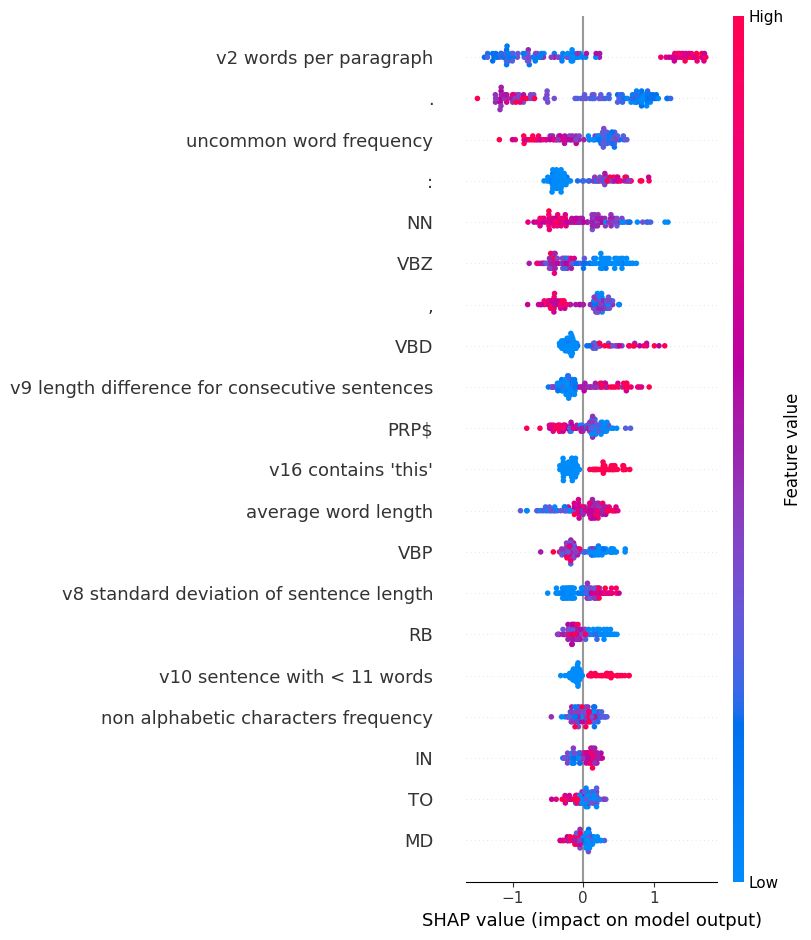

<Figure size 640x480 with 0 Axes>

In [32]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    inaugural_loocv_figure_dir_path.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

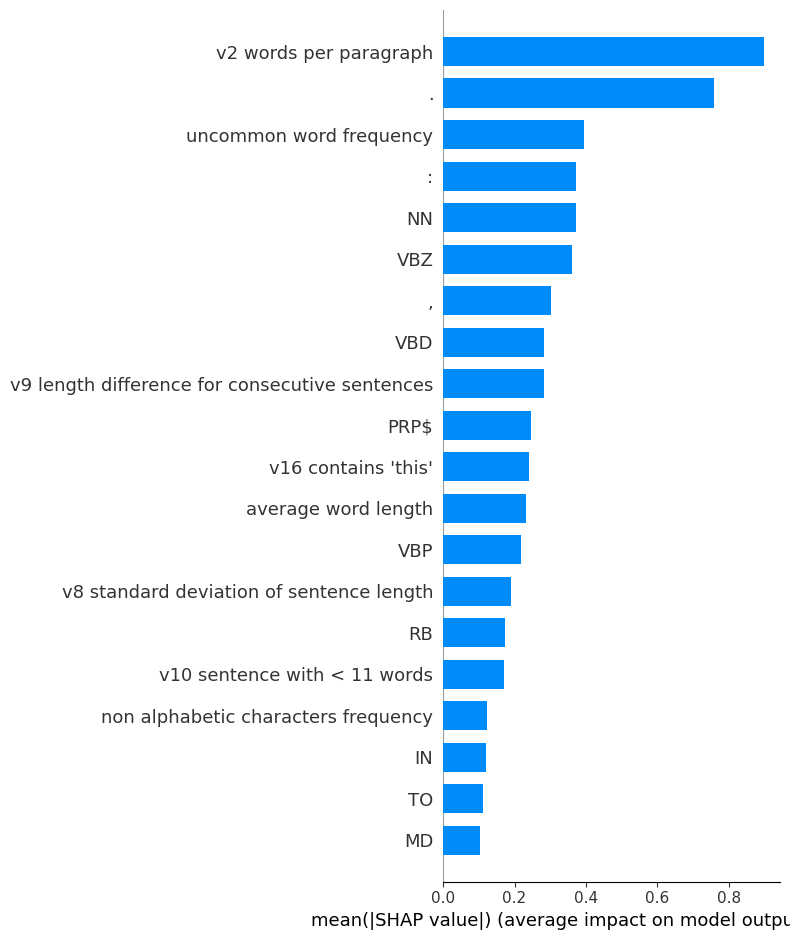

<Figure size 640x480 with 0 Axes>

In [33]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    inaugural_loocv_figure_dir_path.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()